# Final Exam Project - Applied Machine Learning and Data Engineering in Business Context

In [ ]:
# Imports of necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
import time
from scipy.stats import skew


## Dataset description
**Sales**	- Unit sales (in thousands) at each location  <br>
**CompPrice**	- Competitor's price at each location  <br>
**Income** - Income level (in thousand USD)  <br>
**Advertising**	- Advertising budget at each location (in thousands)  <br>
**Population**- Population size (in thousands) <br>
**Price** - Price for car seats at each location in USD <br>
**ShelveLoc** - A variable with levels Bad, Good and Medium indicating the quality of the shelving space at each location <br>
**Age** - Average age of customers <br>
**Education**	- Education level of customers <br>
**Urban** - A variable with levels No and Yes to indicate if store is in an urban or rural location <br>
US - A variable with levels No and Yes to indicate if store is located in the US or not <br>

## Preprocessing

In [ ]:
# Loading dataset
df = pd.read_csv('/content/Carseats.csv')

# Inspection of first 5 rows
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [ ]:
# Number of rows and columns
df.shape

(400, 11)

In [ ]:
# Checking key information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [ ]:
# Handling categorical variables
encoder = LabelEncoder()
categorical_columns = ['ShelveLoc', 'Urban', 'US']
label_mappings = {}

# Manually encode 'ShelveLoc' to preserve order: Bad (0), Medium (1), Good (2)
shelveloc_mapping = {'Bad': 0, 'Medium': 1, 'Good': 2}
df['ShelveLoc'] = df['ShelveLoc'].map(shelveloc_mapping)
label_mappings['ShelveLoc'] = shelveloc_mapping

# Print unique categorical values
for col in categorical_columns:
    if col != 'ShelveLoc':  # Skip 'ShelveLoc' as it's already encoded
        print(df[col].unique())
        df[col] = encoder.fit_transform(df[col])
        label_mappings[col] = {index: label for index, label in enumerate(encoder.classes_)}

['Yes' 'No']
['Yes' 'No']


In [ ]:
# Checking the mapping for the columns
print(label_mappings['Urban'])
print(label_mappings['ShelveLoc'])
print(label_mappings['US'])


{0: 'No', 1: 'Yes'}
{'Bad': 0, 'Medium': 1, 'Good': 2}
{0: 'No', 1: 'Yes'}


In [ ]:
# Checking for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64


## EDA

In [ ]:
# Summary statistics
df.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,0.972500,53.322500,13.900000,0.705000,0.645000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,0.672961,16.200297,2.620528,0.456614,0.479113
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,0.000000,25.000000,10.000000,0.000000,0.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,1.000000,39.750000,12.000000,0.000000,0.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,1.000000,54.500000,14.000000,1.000000,1.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,1.000000,66.000000,16.000000,1.000000,1.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,2.000000,80.000000,18.000000,1.000000,1.000000


In [ ]:
# Check for skewness
df['Sales'].skew()

0.18556036318721578

A skewness value of 0.19 indicates a fairly symmetrical distribution which means transformations are not necessary.

In [ ]:
# Set a style for the plots
sns.set_style('whitegrid')

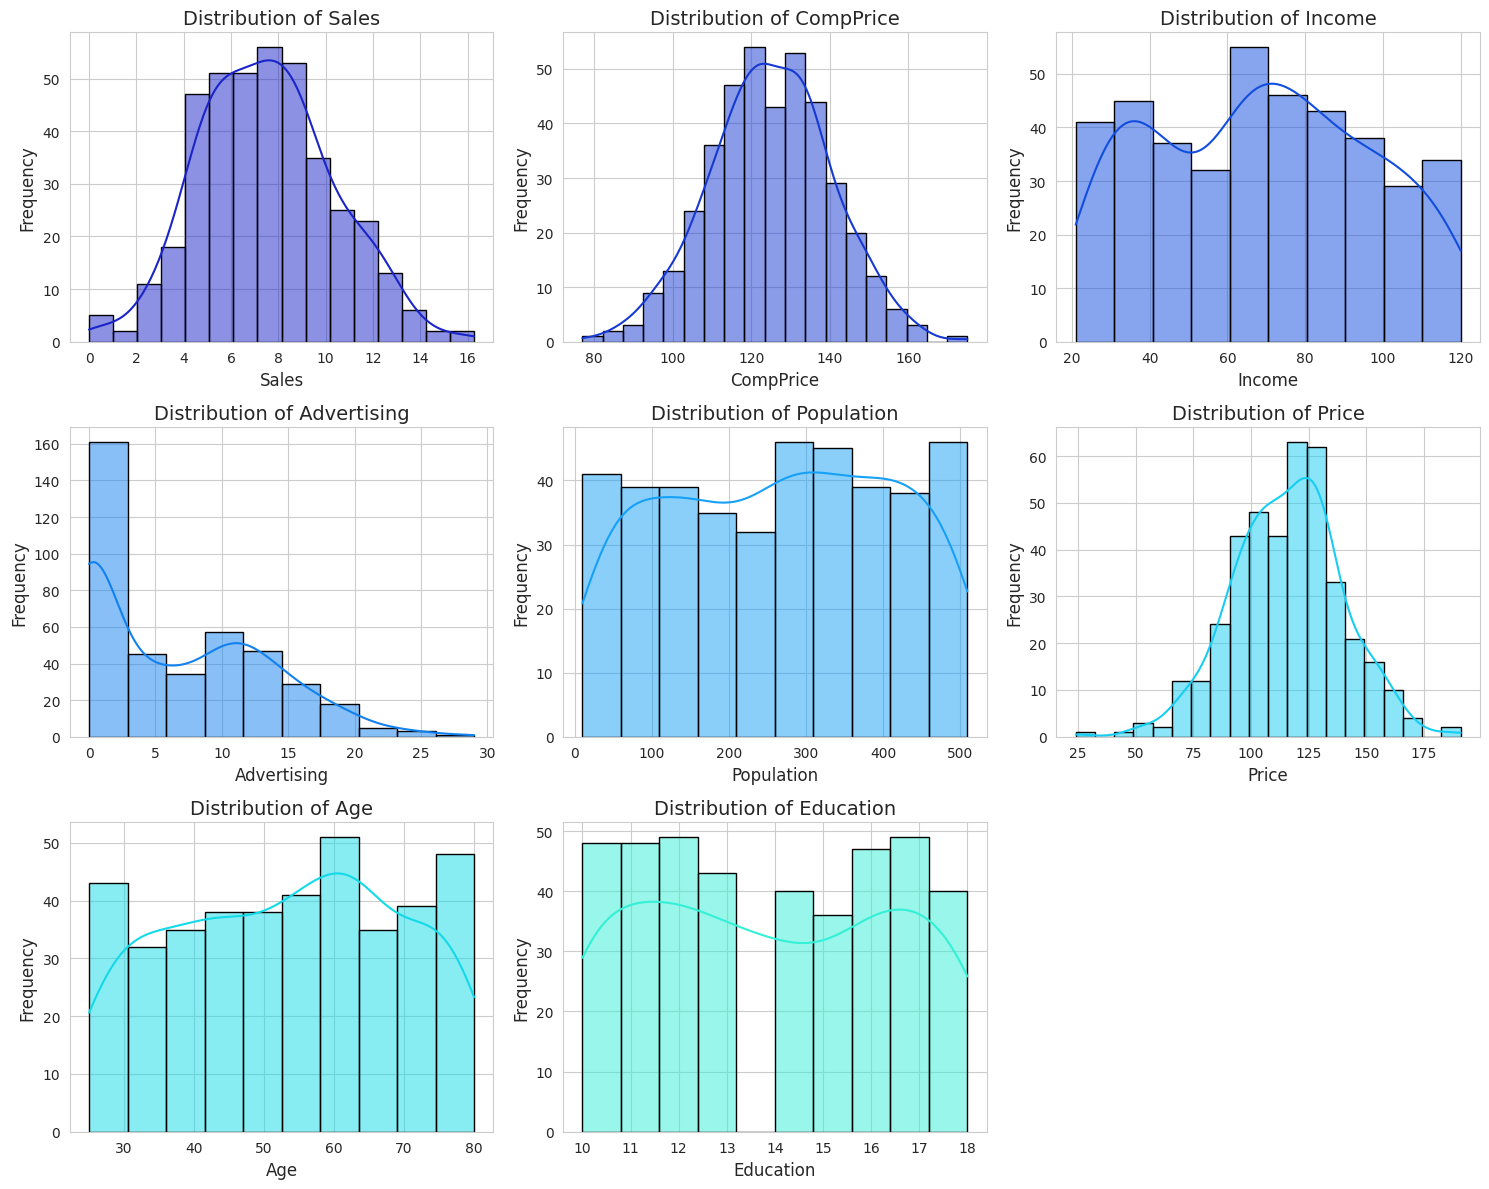

In [ ]:
# Define the color palette
colors = ['#1A24C9', '#1639D3', '#114DDE', '#1281F0', '#16A0F7', '#16CDF3' ,'#12DAE8' ,'#33F0D6' ,'#5AF7D1', '#0D62E8']

# Creating the histogram plots
plt.figure(figsize=(15, 12))
numerical_columns = ['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']
for i, col in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True, color=colors[i % len(colors)], edgecolor='black')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

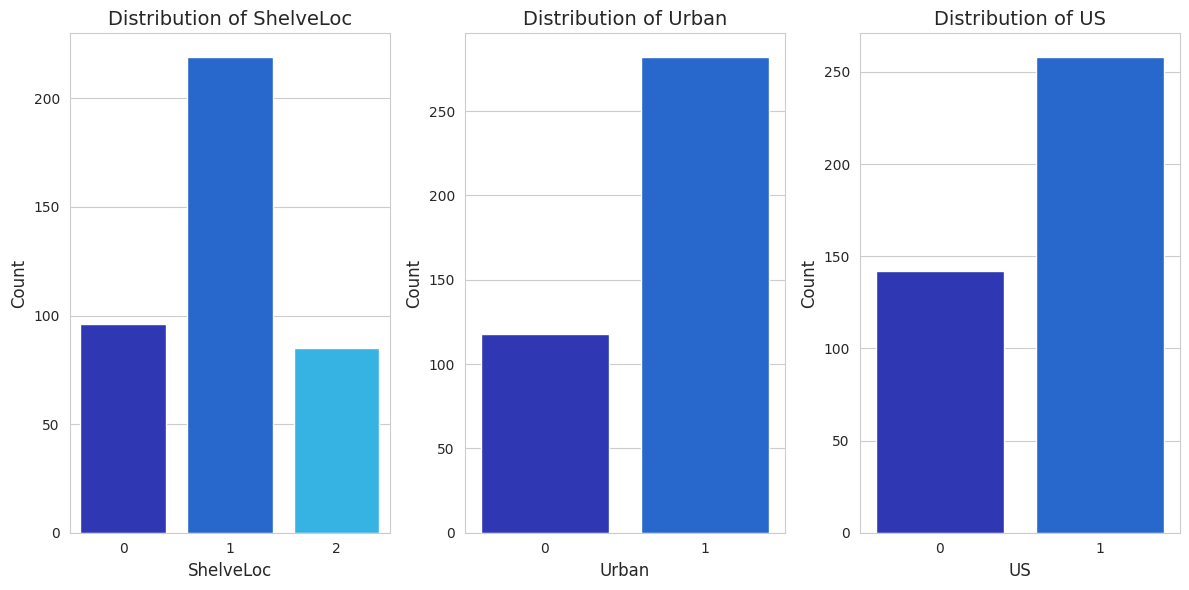

In [ ]:
colors = ['#1A24C9', '#0D62E8', '#1BBFFF', '#0DE8DC', '#80FFCB']

# Categorical variables visualization
plt.figure(figsize=(12, 6))
for i, col in enumerate(categorical_columns):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=df[col], palette=sns.color_palette(colors))
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
#  Check for outliers function
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_thresholds = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')

    outliers = df[(df[column] < outlier_thresholds[0]) | (df[column] > outlier_thresholds[1])]
    return outliers

Number of outliers in Sales: 2
Number of outliers in CompPrice: 2
Number of outliers in Income: 0
Number of outliers in Advertising: 0
Number of outliers in Population: 0
Number of outliers in Price: 5
Number of outliers in ShelveLoc: 181
Number of outliers in Age: 0
Number of outliers in Education: 0
Number of outliers in Urban: 0
Number of outliers in US: 0


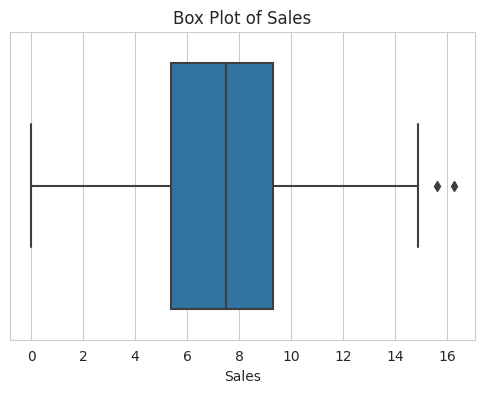

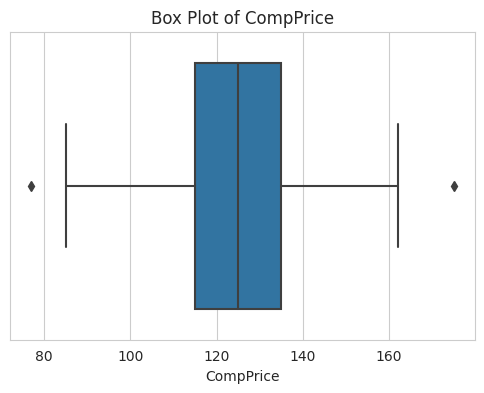

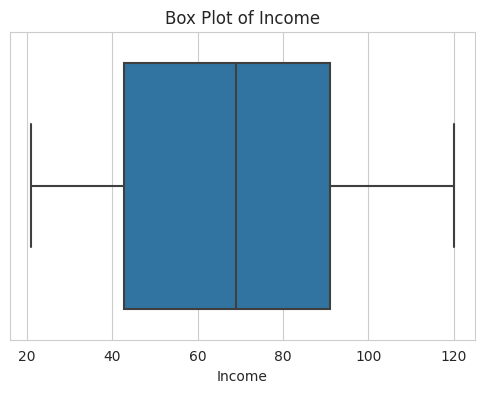

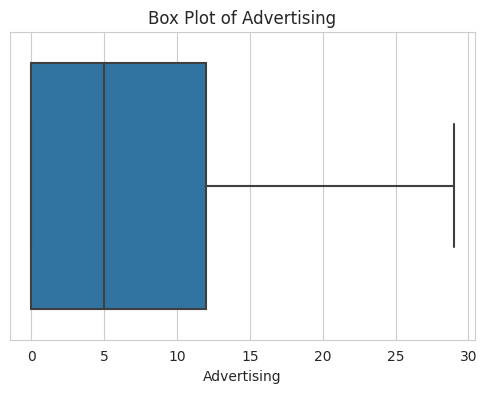

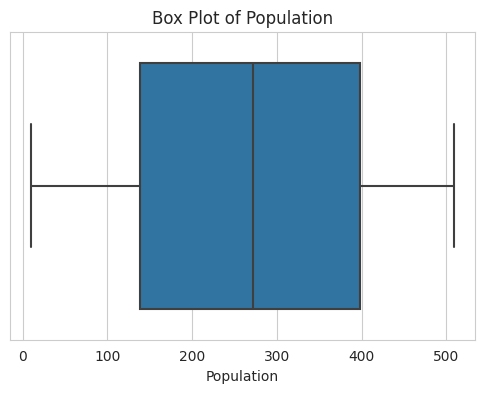

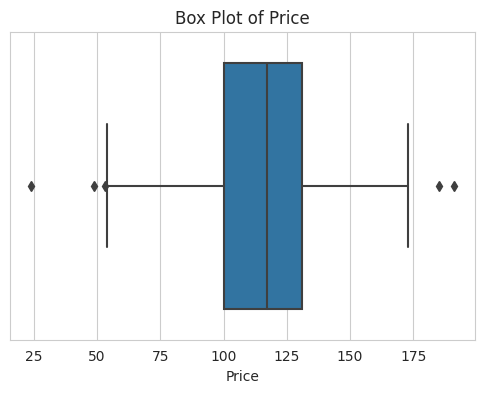

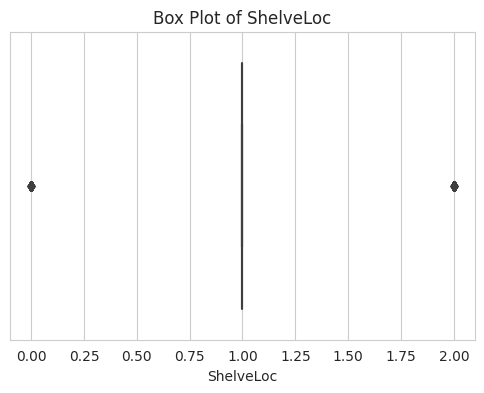

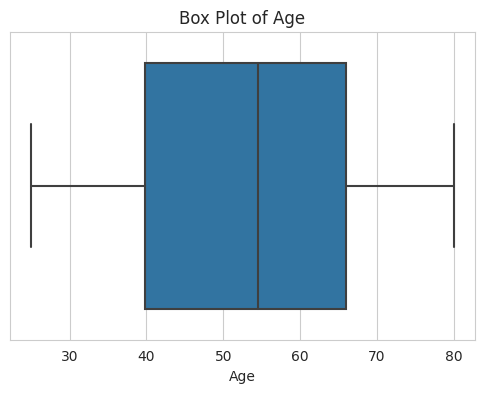

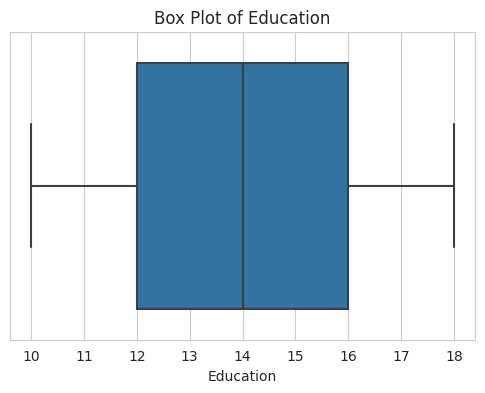

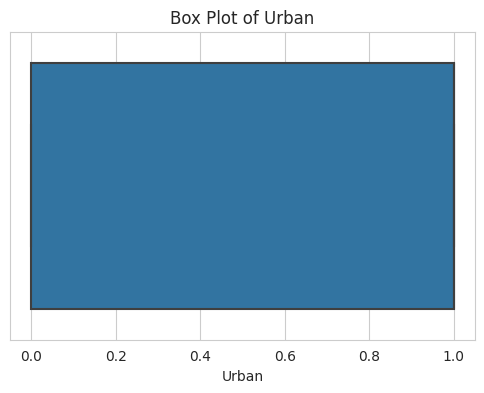

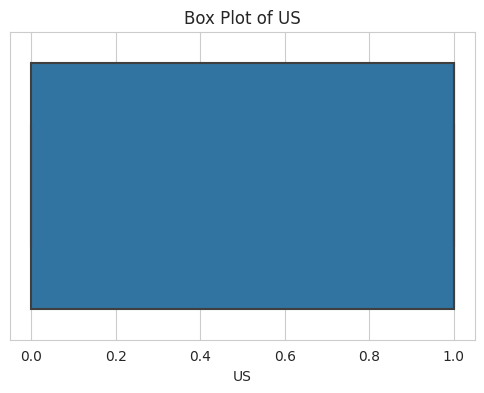

In [ ]:
# Check outliers
for col in df.select_dtypes(include=[np.number]).columns:
    outliers = identify_outliers(df, col)
    print(f'Number of outliers in {col}: {len(outliers)}')

# Pattern Recognition

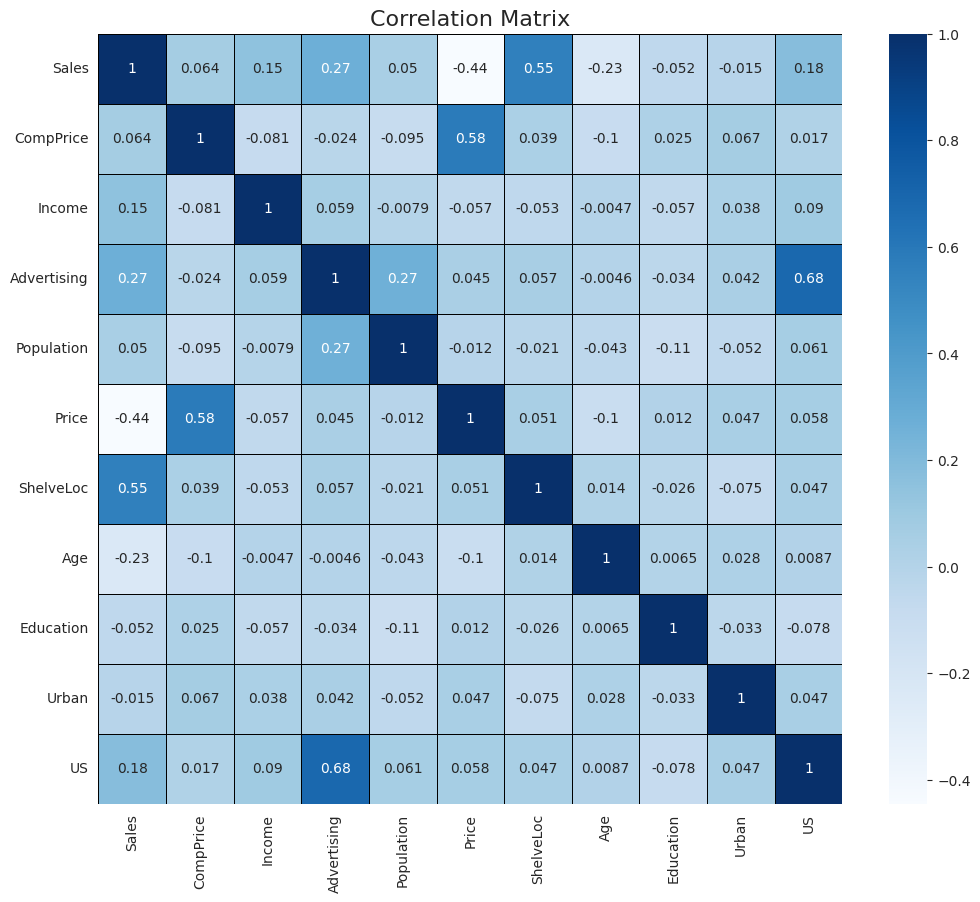

In [ ]:
# Correlation Matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5, linecolor='black')
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

There is a visible positive correlation between price and compprice of 0.58 and between shelveloc and sales of 0.55. In addition to that, advertising & US as a location seem to be highly correlated with a value of 0.68. Sales and price demonstrate a negative correlation with -0.44. The rest of the correlations are rather weak and therefore irrelevant for this analysis.

## Correlation Analysis with Sales for later Sales Prediction

In [ ]:
# Extract correlations with 'Sales'
sales_correlations = correlation_matrix['Sales'].sort_values(ascending=False)

# Display correlations with 'Sales'
print("Correlations with Sales:")
print(sales_correlations)


Correlations with Sales:
Sales          1.000000
ShelveLoc      0.554458
Advertising    0.269507
US             0.177093
Income         0.151951
CompPrice      0.064079
Population     0.050471
Urban         -0.015419
Education     -0.051955
Age           -0.231815
Price         -0.444951
Name: Sales, dtype: float64


This analysis demonstrates that shelveloc and sales have the highest positive correlation followed by advertising and US. The most negative correlation is between price and sales which shows that price has a negative effect on sales.

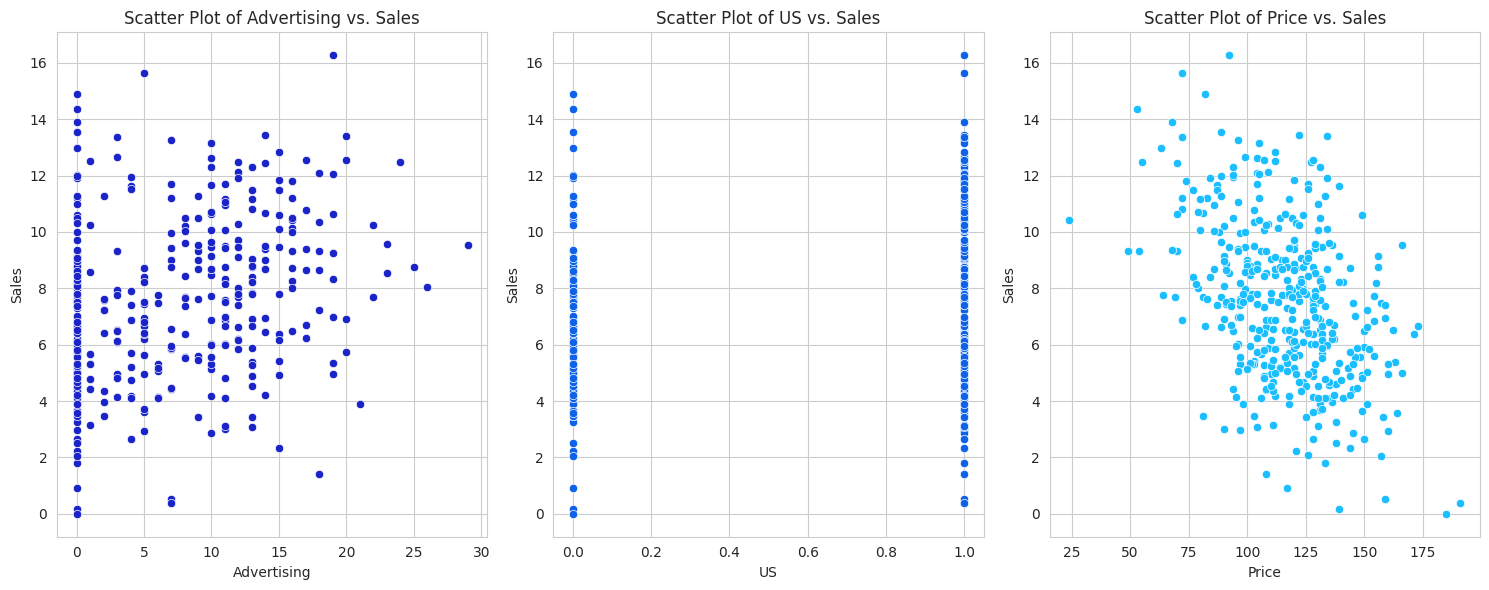

In [ ]:
# scatterplot to visualize the correlations between sales, advertising, US and price
numeric_vars = ['Advertising', 'US', 'Price']
fig, axes = plt.subplots(1, len(numeric_vars), figsize=(15, 6))
for i, var in enumerate(numeric_vars):
    sns.scatterplot(x=df[var], y=df['Sales'], ax=axes[i], color=colors[i % len(colors)])
    axes[i].set_title(f'Scatter Plot of {var} vs. Sales')
plt.tight_layout()
plt.show()

Negative correlation between price and sales the most visible. Plots of advertising and US are rather useless.

In [ ]:
# Separate the outcome variable 'Sales' from the features
X = df.drop(columns=['Sales'])
y = df['Sales']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Principal Component Analysis

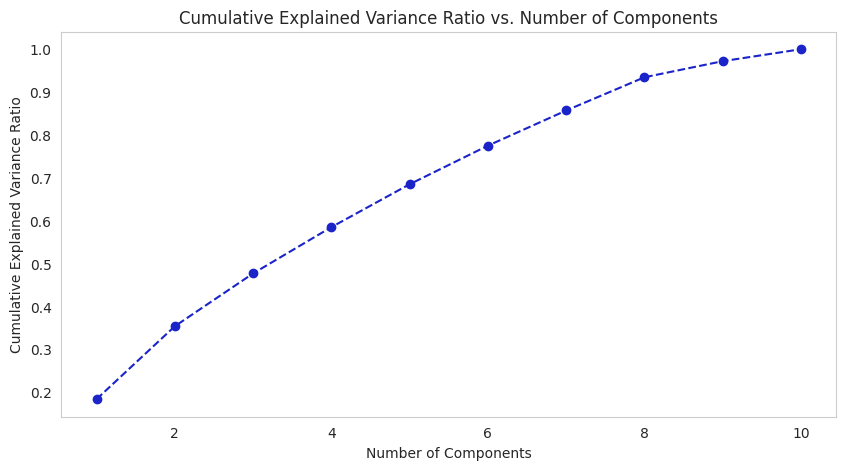

Number of components to retain 95.00% of the variation: 9


In [ ]:
# Applying PCA
pca = PCA()
pca.fit(X_train_scaled)

# Explained variance ratio to decide the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--', color=colors[0])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid()
plt.show()
# Determine the number of components to retain 95% of variation
desired_variance_ratio = 0.95
n_components = np.argmax(cumulative_variance_ratio >= desired_variance_ratio) + 1

print(f"Number of components to retain {desired_variance_ratio * 100:.2f}% of the variation: {n_components}")

# Perform PCA with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


PCA retains 9 out of 10 columns to explain 95% of the variance. That suggests that the data has a high degree of multidimensionality and the variables are not strongly correlated. In such cases, PCA might not be as effective in reducing the dimensionality without losing a significant amount of information.

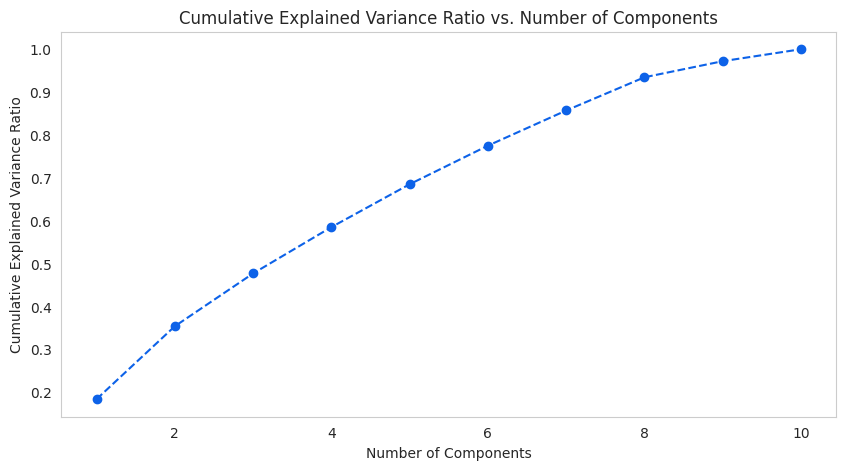

Number of components to retain 98.00% of the variation: 10


In [ ]:
# PCA with higher cumulative variance threshold (98%)
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA
pca = PCA()
pca.fit(X_train_scaled)

# Explained variance ratio to decide the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--', color=colors[1])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid()
plt.show()

# Determine the number of components to retain 98% of variation
desired_variance_ratio = 0.98
n_components = np.argmax(cumulative_variance_ratio >= desired_variance_ratio) + 1

print(f"Number of components to retain {desired_variance_ratio * 100:.2f}% of the variation: {n_components}")

# Perform PCA with the selected number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

PCA retains 10 out of 10 columns to explain 98% of the variance suggesting that the variance in the dataset is spread out across many features, and no small subset of features captures a dominant portion of the total variance.
PCA not really necessary in that case.

<ipython-input-23-b73058dfb8f2>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xs * scalex, ys * scaley, cmap='viridis', alpha=0.5)


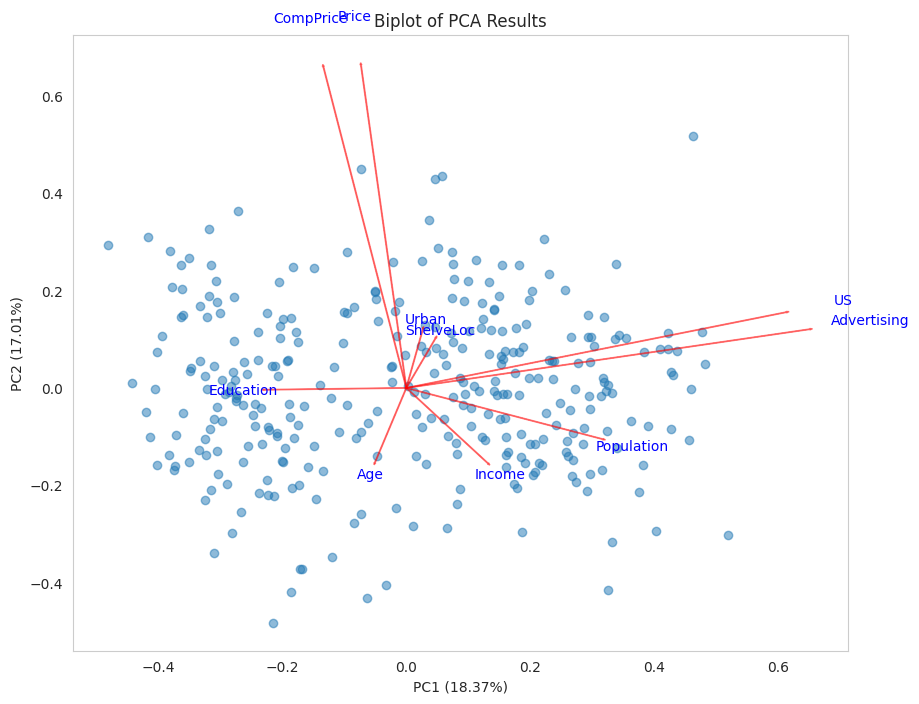

In [ ]:
# biplot to visualize
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, cmap='viridis', alpha=0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, f"Var{i+1}", color='b', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='b', ha='center', va='center')
    plt.xlabel(f'PC1 ({explained_variance_ratio[0] * 100:.2f}%)')
    plt.ylabel(f'PC2 ({explained_variance_ratio[1] * 100:.2f}%)')
    plt.title('Biplot of PCA Results')
    plt.grid()

# Assuming you have already executed PCA
# Create labels for all variables (excluding 'Sales')
feature_labels = df.drop(columns=['Sales']).columns

# Plot the biplot
biplot(X_train_pca, np.transpose(pca.components_[0:2, :]), labels=feature_labels)

# Show the biplot
plt.show()


The lack of clustering suggests that the dataset does not have distinct, separable groups or segments, at least not in the dimensions captured by the first two principal components.


# Machine Learning Models: Prediction  of Sales data
## Random Forest Regressor



In [ ]:
colors = ['#1A24C9', '#1639D3', '#114DDE', '#1281F0', '#16A0F7', '#16CDF3' ,'#12DAE8' ,'#33F0D6' ,'#5AF7D1', '#0D62E8']

# Function to display cross-validation results
def display_cv_results(cv_results):
    cv_result_df = pd.DataFrame(cv_results)
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 7))

    # Iterate through the rows of the DataFrame
    for i, row in cv_result_df.iterrows():
        if np.isnan(row['mean_test_score']):
            continue
        plt.scatter(x=row['param_n_estimators'], y=np.sqrt(-row['mean_test_score']),
                    label=f'Tree {row["param_n_estimators"]}', color=colors[i % len(colors)])

    plt.xlabel("Number of Trees (n_estimators)")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.legend()
    plt.title("Cross-Validation Results")
    plt.show()

# Function to fit, predict and evaluate and print model performance
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("Model Performance:")
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'R2 Score: {r2:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')

#Function to display Feature Importance for each model
def plot_feature_importance(model, feature_names, top_n=10, colors=colors):
    feature_importances = getattr(model, 'feature_importances_', None)
    if feature_importances is None:
        print("Feature importances not available for the given model.")
        return
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n), palette=sns.color_palette(colors))
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title('Feature Importances', fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()



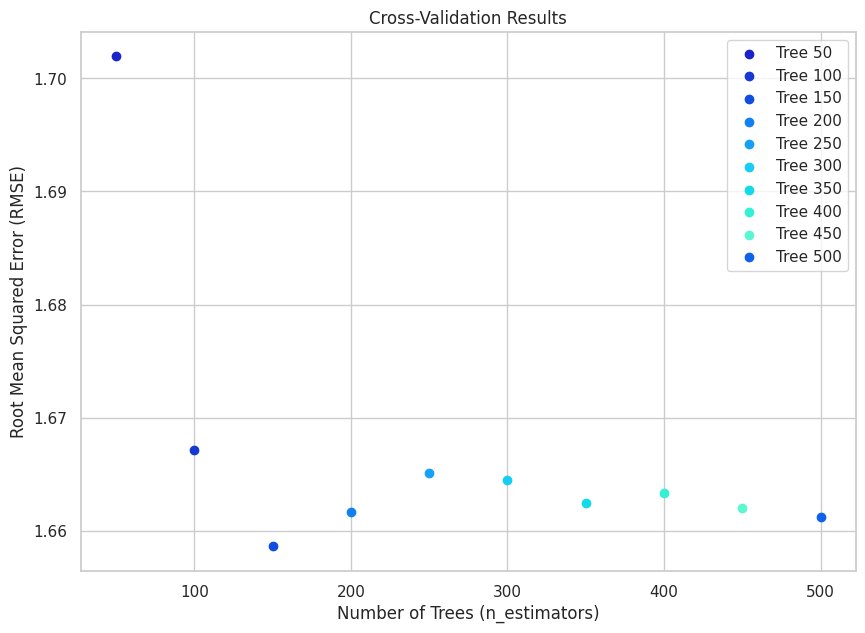

In [ ]:
# Random Forest
max_features = X_train.shape[1]
regressor_rf = RandomForestRegressor(max_features=max_features, random_state=42)
param_grid = {
    'n_estimators': [i for i in range(50, 550, 50)]
}
#apply gridsearch cross validation
reg_cv = GridSearchCV(regressor_rf, param_grid, cv=5, scoring='neg_mean_squared_error')
reg_cv.fit(X_train, y_train)
# Display cross-validation results
display_cv_results(reg_cv.cv_results_)



In [ ]:
# Use the best estimator directly for evaluation
start_time = time.time()
evaluate_model(reg_cv.best_estimator_, X_train, y_train, X_test, y_test)
end_time = time.time()
print(f"Cell execution time: {end_time - start_time} seconds")


Model Performance:
Mean Squared Error: 3.05
Mean Absolute Error: 1.42
R2 Score: 0.69
Root Mean Squared Error: 1.75
Cell execution time: 0.3930652141571045 seconds


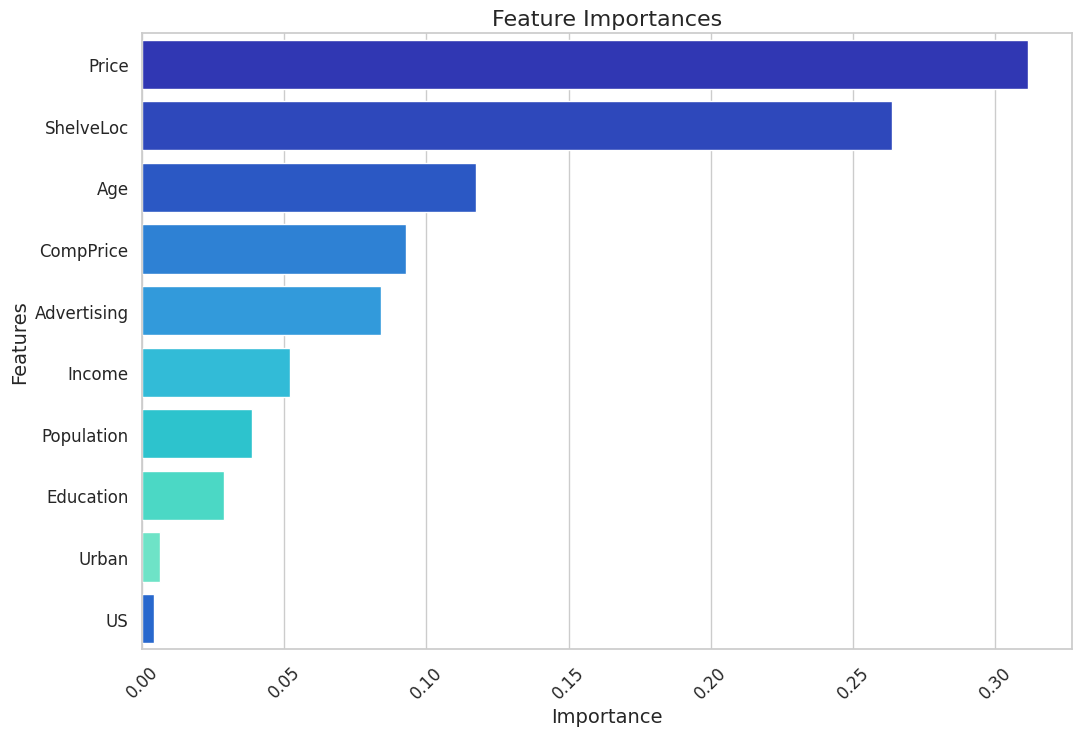

In [ ]:
plot_feature_importance(reg_cv.best_estimator_, X_train.columns)

# XGBoost

In [ ]:
# XGBoost
regressor_xgb = xgb.XGBRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

# Perform grid search cross-validation
reg_cv_xgb = GridSearchCV(regressor_xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
reg_cv_xgb.fit(X_train, y_train)

# Use the best estimator directly for evaluation
best_xgb_estimator = reg_cv_xgb.best_estimator_

In [ ]:
start_time = time.time()
evaluate_model(best_xgb_estimator, X_train, y_train, X_test, y_test)
end_time = time.time()
print(f"Cell execution time: {end_time - start_time} seconds")

Model Performance:
Mean Squared Error: 1.90
Mean Absolute Error: 1.11
R2 Score: 0.81
Root Mean Squared Error: 1.38
Cell execution time: 0.07665896415710449 seconds


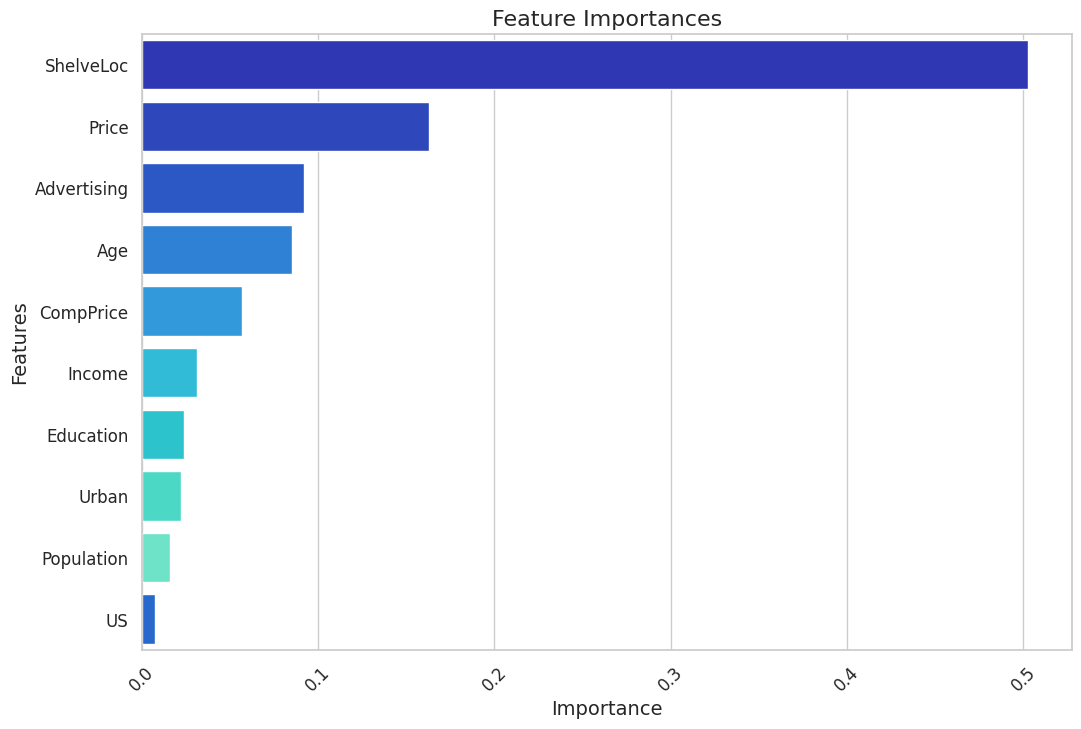

In [ ]:
plot_feature_importance(best_xgb_estimator, X_train.columns)

## Bagging

In [ ]:
base_bagging = DecisionTreeRegressor(random_state=42, max_depth=7)

# Bagging Regressor
bagging = BaggingRegressor(estimator=base_bagging, random_state=42)

# Define the parameter grid for grid search
param_grid_bagging = {
    'n_estimators': [50, 100, 200],
    'bootstrap': [True, False]
}

# Perform grid search cross-validation
reg_cv_bagging = GridSearchCV(bagging, param_grid_bagging, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
reg_cv_bagging.fit(X_train, y_train)
best_bagging_estimator = reg_cv_bagging.best_estimator_


In [ ]:
start_time = time.time()
evaluate_model(best_bagging_estimator, X_train, y_train, X_test, y_test)
end_time = time.time()
print(f"Cell execution time: {end_time - start_time} seconds")


Model Performance:
Mean Squared Error: 3.15
Mean Absolute Error: 1.47
R2 Score: 0.68
Root Mean Squared Error: 1.77
Cell execution time: 0.5064127445220947 seconds


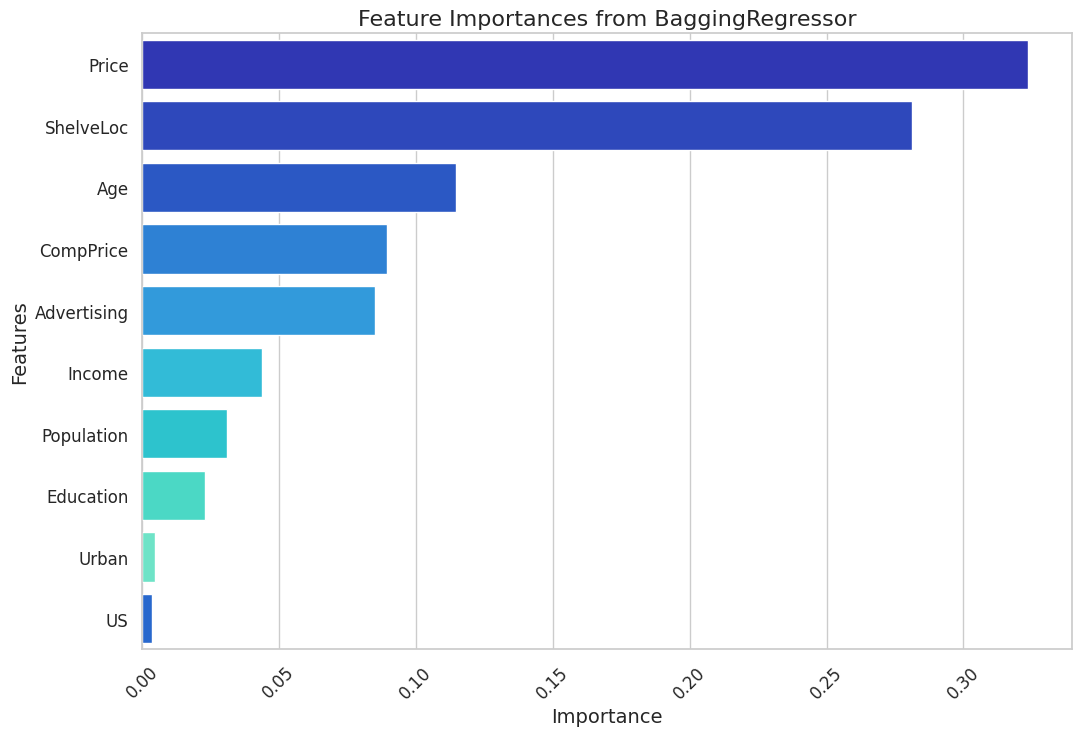

In [ ]:
# Display feature importance for BaggingRegressor
bagging_feature_importances = np.mean([tree.feature_importances_ for tree in best_bagging_estimator.estimators_], axis=0)
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': bagging_feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette=sns.color_palette(colors))
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importances from BaggingRegressor', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## Gradient Boosting

In [ ]:

gb = GradientBoostingRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'max_depth': [3, 5, 7]
}

# Perform grid search cross-validation
reg_cv_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
reg_cv_gb.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
best_gb_estimator = reg_cv_gb.best_estimator_
start_time = time.time()
evaluate_model(best_gb_estimator, X_train, y_train, X_test, y_test)
end_time = time.time()
print(f"Cell execution time: {end_time - start_time} seconds")

Model Performance:
Mean Squared Error: 1.99
Mean Absolute Error: 1.15
R2 Score: 0.80
Root Mean Squared Error: 1.41
Cell execution time: 0.10414838790893555 seconds


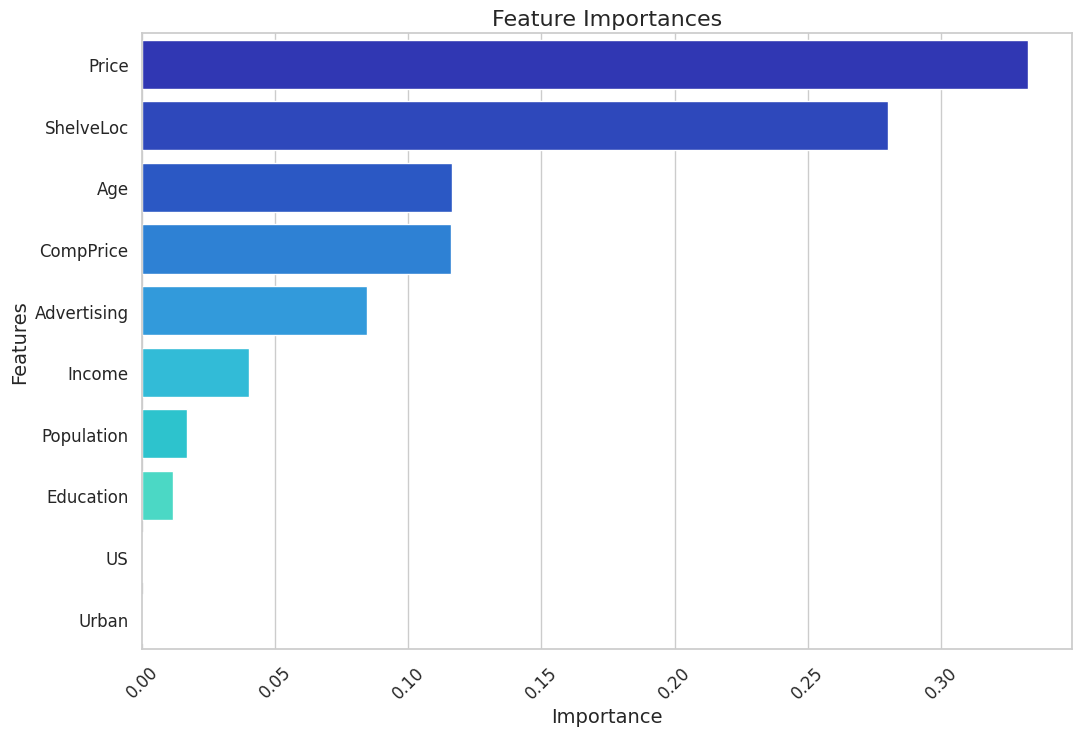

In [ ]:
plot_feature_importance(best_gb_estimator, X_train.columns)

## AdaBoost

In [ ]:
ada_reg = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                            random_state=42)

# Define the parameter grid for grid search
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
}
reg_cv_ada = GridSearchCV(ada_reg, param_grid_ada, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
reg_cv_ada.fit(X_train, y_train)
best_ada_estimator = reg_cv_ada.best_estimator_


In [ ]:
start_time = time.time()
evaluate_model(best_ada_estimator, X_train, y_train, X_test, y_test)
end_time = time.time()
print(f"Cell execution time: {end_time - start_time} seconds")

Model Performance:
Mean Squared Error: 3.16
Mean Absolute Error: 1.45
R2 Score: 0.68
Root Mean Squared Error: 1.78
Cell execution time: 0.5361893177032471 seconds


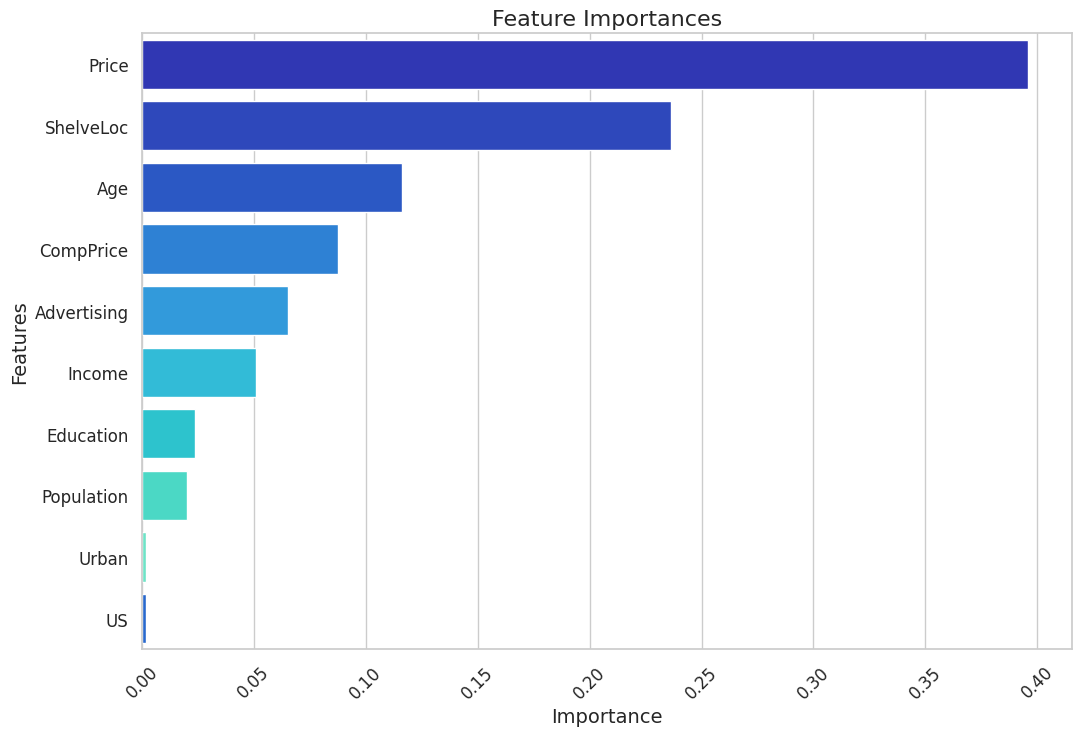

In [ ]:
plot_feature_importance(best_ada_estimator, X_train.columns)

## Baseline Models: Multiple Linear Regression with:
1. Advertising
2. US
3. ShelveLoc
4. Income
5. Age
6. Price

Those are the variables with stronger positive and negative correlations to sales

In [ ]:
# Select the relevant features
selected_features = ['Advertising', 'US', 'ShelveLoc', 'Income', 'Age', 'Price']

# Extract the selected features for training and testing sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


In [ ]:

# Initialize the Linear Regression model
linear_reg_model = LinearRegression()
start_time = time.time()
evaluate_model(linear_reg_model, X_train_selected, y_train, X_test_selected, y_test)
end_time = time.time()
print(f"Cell execution time: {end_time - start_time} seconds")

Model Performance:
Mean Squared Error: 3.14
Mean Absolute Error: 1.45
R2 Score: 0.68
Root Mean Squared Error: 1.77
Cell execution time: 0.02364969253540039 seconds


## XGBoost with limited Features

In [ ]:
# XGBoost with limited features - variance of about 70%

# Data preparation
# Separate the outcome variable 'Sales' from the features
X = df.drop(columns=['Sales', 'US', 'Urban', 'Population', 'Education'])
y = df['Sales']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# XGBoost
regressor_xgb = xgb.XGBRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid_xgb = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.1, 0.5, 0.75 , 1.0]
}

# Perform grid search cross-validation
reg_cv_xgb = GridSearchCV(regressor_xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
reg_cv_xgb.fit(X_train, y_train)

# Use the best estimator directly for evaluation
best_xgb_estimator = reg_cv_xgb.best_estimator_

In [ ]:
start_time = time.time()
evaluate_model(best_xgb_estimator, X_train, y_train, X_test, y_test)
end_time = time.time()
print(f"Cell execution time: {end_time - start_time} seconds")

Model Performance:
Mean Squared Error: 1.81
Mean Absolute Error: 1.09
R2 Score: 0.82
Root Mean Squared Error: 1.34
Cell execution time: 0.04483675956726074 seconds


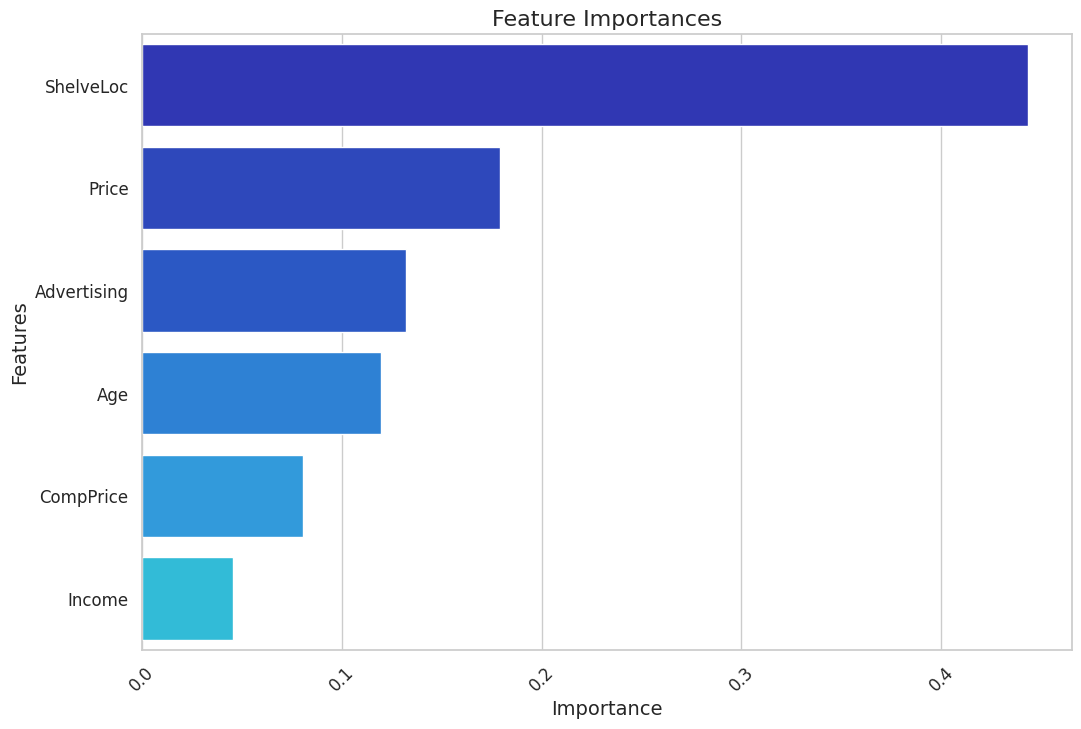

In [ ]:
plot_feature_importance(best_xgb_estimator, X_train.columns)